These tutorials are very brief and aim to get you started. They are not replacements for official documentation or for understanding the finer points of deep learning methods.

Goal: The main aim of this notebook is to demonstrate the main building blocks for training a neural network in PyTorch

### Imports

In [1]:
import torch #pytorch
import torch.nn as nn #nn submodule with convenience functions for defining neural nets
import torch.optim as optim #optim submodule for gradient descent (don't worry about this for now)

import numpy as np 
import matplotlib.pylab as plt
%matplotlib inline

### Toy dataset

In [38]:
def gen_data(N=100):

    def gen_points(N, r_low, r_high, label):
        r = np.random.uniform(r_low, r_high, size=N)
        theta = np.random.uniform(0, 2*np.pi, size=N)
        #since someone asked this question, no! the above method doesn't
        #generate points uniformly in the unit disk!
    
        X = np.vstack([r*np.cos(theta), r*np.sin(theta)])
        y = np.array([label]*N)
        
        return X, y
    
    X1, y1 = gen_points(N, 0, 1, 0)
    X2, y2 = gen_points(N, 3, 4, 1)
    
    X = np.hstack([X1, X2])
    y = np.hstack([y1, y2])
    
    return X.T, y

def plot_data(X, y):
    plt.figure(figsize=(10,10))
    plt.plot(X[y==0][:,0], X[y==0][:, 1], 'p', c='g', label='0')
    plt.plot(X[y==1][:,0], X[y==1][:, 1], 'p', c='r', label='1')
    plt.legend()

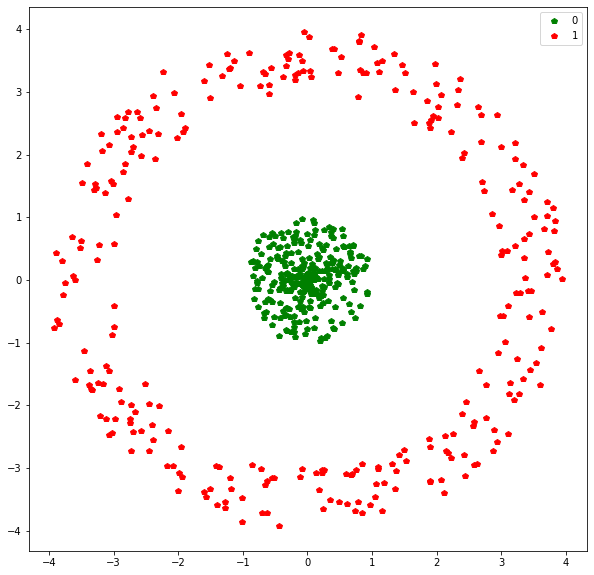

In [39]:
X, y = gen_data(N=300)
plot_data(X, y)

The above dataset consists of two types of points. Reds have large radius while greens have small radius. We want to train a neural network to determine if a point is red (1) or green (0) given its (x,y) coordinates. This is a toy problem but contains the essential ingredients of a training loop. 

You can think of a neural network as a parameterized (i.e. depending on some free parameters) map from (x,y) coordinates to the probability that a point belongs to class 1. If the probability is low, we'll consider the point green (0) and if the probability is high, we'll consider the point red (1).

### Defining the neural network

In [41]:
#skipping some details for first pass

net = nn.Sequential(nn.Linear(2, 32), #map 2 numbers (x and y) to 32 numbers (the 32 is arbitrary for now)
                    nn.ReLU(), #each of the 32 numbers goes through a thresholding function
                    nn.Linear(32, 1)) #map 32 numbers to 1 (probability point belongs to class 1) number



**Notable point 1**:

The maps nn.Linear(m, n) are linear maps i.e. they map a vector $\vec{x}$ to a vector $\vec{y}$ as follows:

$$\vec{y} = A\vec{x} + \vec{b}$$

where $\vec{x}$ is an m-dimensional vector and $\vec{y}$ is an n-dimensional vector.

This implies that $\vec{b}$ is n-dimensional and the matrix $A$ is $n$ x $m$.

**Notable point 2**:

Both $A$ and $b$ (or the elements thereof) are free parameters called **weights** or sometimes just **parameters**. Sometimes people also call $A$ weights and $b$ the bias (or biases).

**Notable point 3**:

When a neural network is initialized i.e. when the nn.Sequential constructor is called, these weights are initialized randomly. 

**Notable point 4**:

Each choice of $A$ and $b$ defines one map from (x,y) coordinates (the "2" in the first nn.Linear specification) to the probability (the "1" in the second argument of the last nn.Linear specification). We'll repeatedly initialize this neural network and plots its "predictions" given a set of (x,y) coordinates below.

**Notable point 5**:

Training refers to the problem of finding the appropriate weights $A$ and $b$ such that the neural network maps all the points labeled green to low probabilities and all the points labeled red to high probabilities.

**Notable point 6**:

Enforcing this requirements that reds map to high probabilities and greens map to low probabilities is done by converting the problem of "training" or "learning" into a mathematical optimization problem. In other words, the network is used to make predictions for all (x,y) coordinates, the predictions are compared to the actual labels to compute an error and then the weights are adjusted to minimize the error. This is where backpropagation and gradient descent come in.

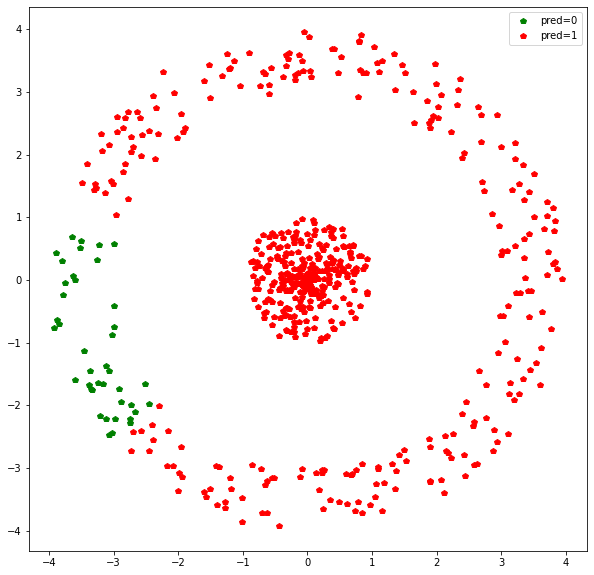

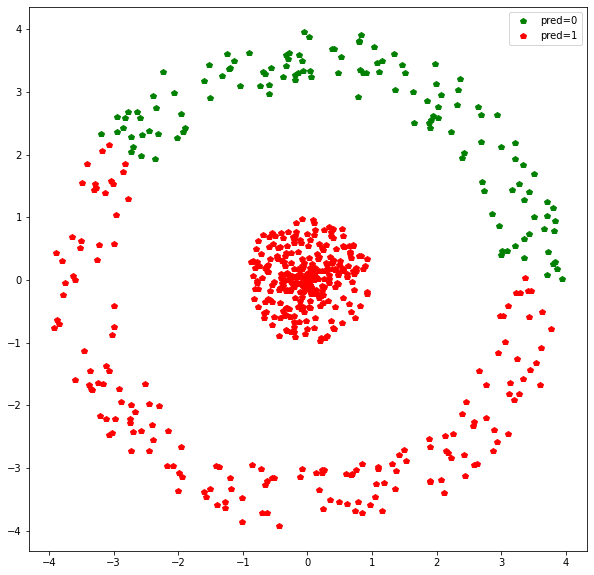

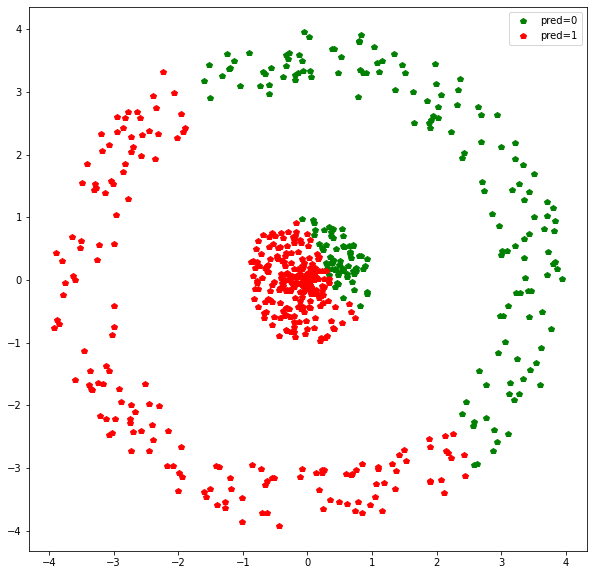

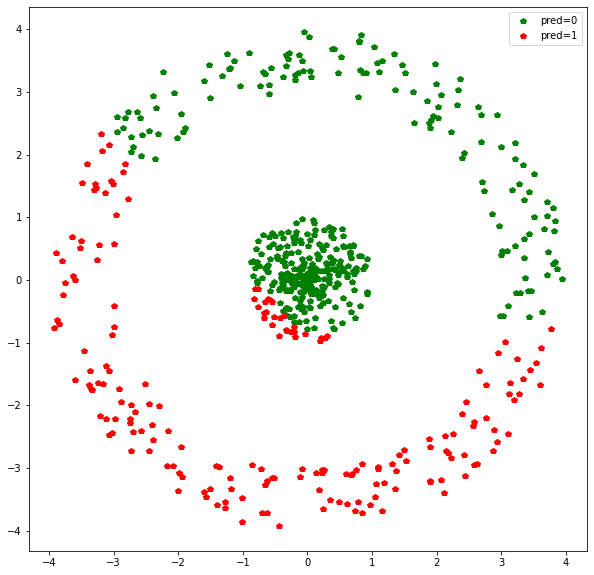

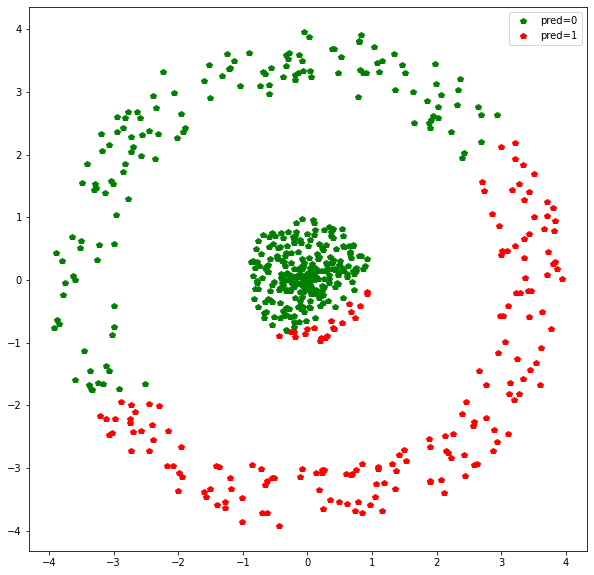

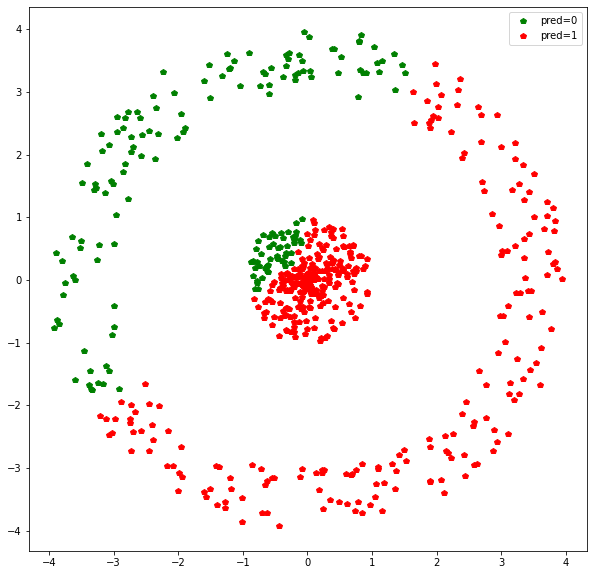

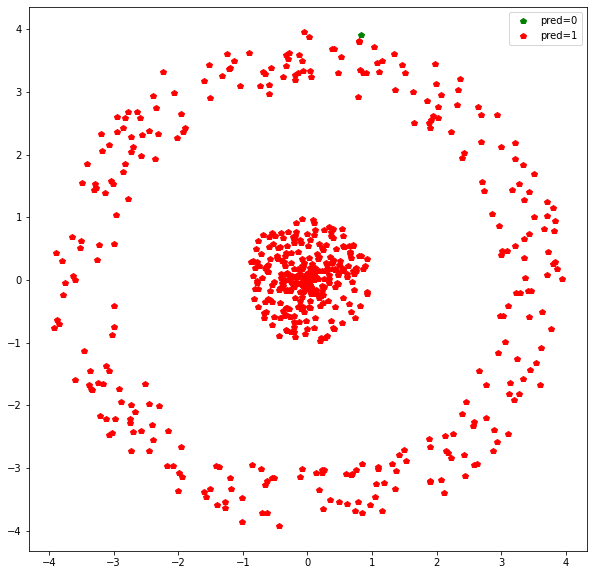

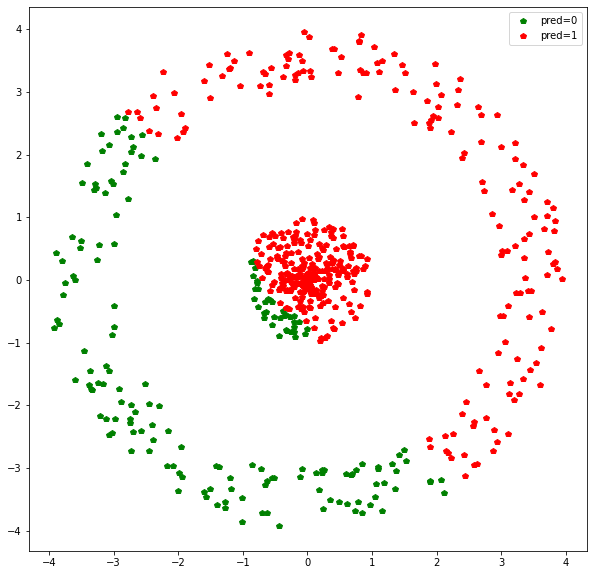

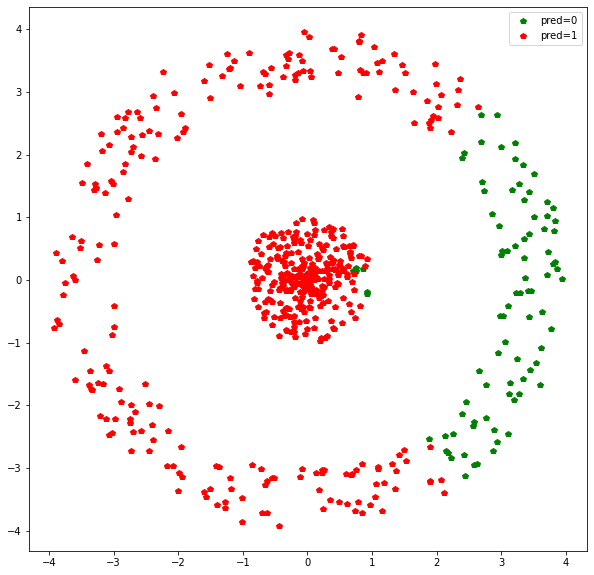

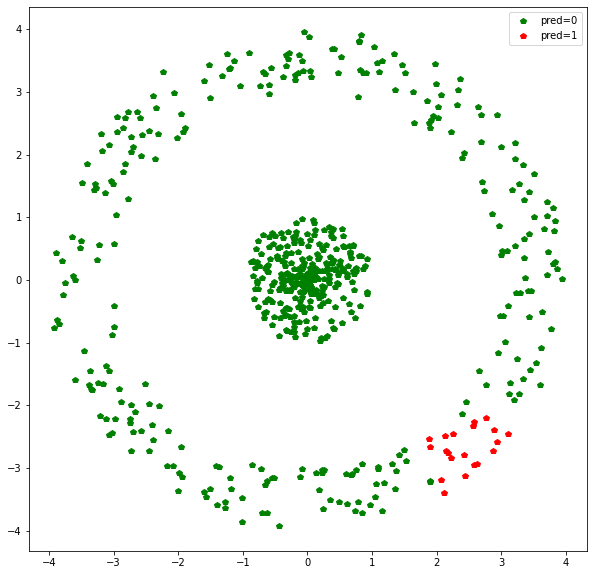

In [61]:
for _ in range(10):
    net = nn.Sequential(nn.Linear(2, 32), #map 2 numbers (x and y) to 32 numbers (the 32 is arbitrary for now)
                        nn.ReLU(), #each of the 32 numbers goes through a thresholding function
                        nn.Linear(32, 1)) #map 32 numbers to 1 (probability point belongs to class 1) number
    
    pred = nn.Sigmoid()(net(torch.from_numpy(X).float()))
    pred = (pred > 0.5).int().numpy().squeeze(1)
    
    plt.figure(figsize=(10,10))
    plt.plot(X[pred==0][:,0], X[pred==0][:, 1], 'p', c='g', label='pred=0')
    plt.plot(X[pred==1][:,0], X[pred==1][:, 1], 'p', c='r', label='pred=1')
    plt.legend()

We are only using the X array in the plots above. For each of the points, a randomly initialized neural network is used to make predictions for the probabilities. All points with probability > 0.5 are labeled red and all with probability <= 0.5 are labeled green. Clearly, none of them get all the predictions correct (center blob = green and annulus = red).

For a given net, we can look at the weights:

In [65]:
params = list(net.parameters())
for p in params:
    print('------')
    print(p.shape)
    print(p)

------
torch.Size([32, 2])
Parameter containing:
tensor([[ 0.5135,  0.6636],
        [-0.6604, -0.6389],
        [-0.2184,  0.6559],
        [ 0.3557, -0.2966],
        [-0.5326, -0.1521],
        [-0.3061,  0.6077],
        [ 0.1474, -0.2923],
        [-0.3020, -0.3389],
        [-0.4881, -0.3569],
        [-0.1221, -0.5419],
        [ 0.4605,  0.2697],
        [-0.0359, -0.4084],
        [-0.3249,  0.4203],
        [-0.5545,  0.1439],
        [ 0.4088, -0.0618],
        [ 0.4324,  0.2195],
        [-0.6857, -0.7017],
        [-0.0558,  0.0279],
        [ 0.2224, -0.2425],
        [-0.4140, -0.0050],
        [-0.2544, -0.0799],
        [ 0.5524,  0.6967],
        [-0.5102, -0.4784],
        [-0.4954, -0.4566],
        [-0.2739,  0.3276],
        [ 0.2000, -0.6183],
        [-0.3112, -0.3671],
        [ 0.3266,  0.3804],
        [ 0.4554,  0.2208],
        [-0.0221,  0.1622],
        [-0.2846, -0.0109],
        [ 0.2954,  0.6221]], requires_grad=True)
------
torch.Size([32])
Parameter 

The 32x2 matrix maps the (x,y) coordinate to a 32-dimensional vector. The 32 dimensional bias vector is then added to this result.

The 1x32 matrix maps the 32-dimensional vector from the previous result (layer) to a 1-dimensional (a single number) vector and then the 1-dimensional bias is added to this.

The final result is a single float in this case. To convert is to a probability, we use the so-called sigmoid function which can be thought of as a smooth binary switch.

"\nplt.figure(figsize=(10,10))\nplt.plot(torch.linspace(-10, 10, 100).numpy(), nn.ReLU()(torch.linspace(-10, 10, 100)).numpy())\nplt.xlabel('x')\nplt.ylabel(f'{str(nn.ReLU())}(x)')\nplt.vlines(0, 0, 1, color='r', alpha=0.5)\nplt.hlines(0, -10, 10, color='r', alpha=0.5)\n"

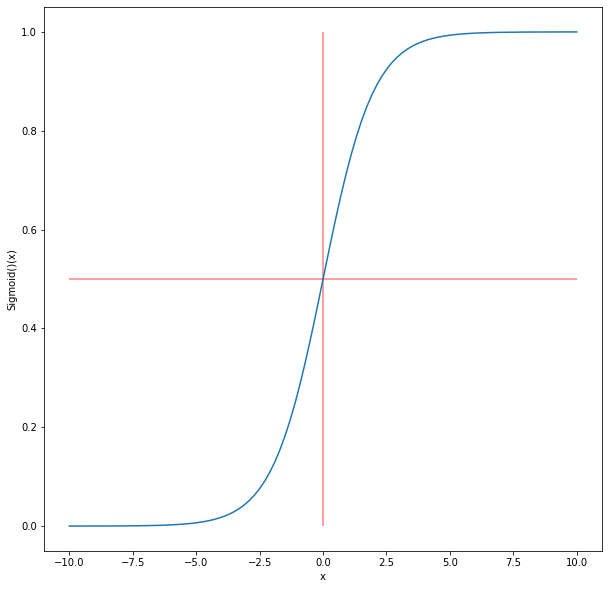

In [85]:

plt.figure(figsize=(10,10))
plt.plot(torch.linspace(-10, 10, 100).numpy(), nn.Sigmoid()(torch.linspace(-10, 10, 100)).numpy())
plt.xlabel('x')
plt.ylabel(f'{str(nn.Sigmoid())}(x)')
plt.vlines(0, 0, 1, color='r', alpha=0.5)
plt.hlines(0.5, -10, 10, color='r', alpha=0.5)

'''
plt.figure(figsize=(10,10))
plt.plot(torch.linspace(-10, 10, 100).numpy(), nn.ReLU()(torch.linspace(-10, 10, 100)).numpy())
plt.xlabel('x')
plt.ylabel(f'{str(nn.ReLU())}(x)')
plt.vlines(0, 0, 1, color='r', alpha=0.5)
plt.hlines(0, -10, 10, color='r', alpha=0.5)
'''

The sigmoid (smooth switch) maps the single float to a value between 0 and 1 which can be interpreted as a probability of the input point belonging to class 1. One can choose a threshold, say 0.5, such that any probability prediction > 0.5 implies the input point belongs to class 1 and class 0 otherwise.

The whole task of training/learning is to adjust the neural network's weights so that the red and green points are classified correctly (there is a subtle point about generalization below).

This is done as follows:

Start with some labeled data: X, y

Start with some neural network with randomly initialized weights

Loop N times:
    Make predictions on X -> p (for predictions i.e. probabilities for each $x \in X$ to belong to class 1)
    
    Compare predictions to labels y. This is done using a loss function and a loss value (or just loss) is computed
    
    The loss is a function of the input data X, the labels y, and the network's weights
    
    Minimize the loss by adjusting the weights. This is done using a gradient-based (first derivative based) approach called gradient descent
    
This loop is shown below. Note there are specific details on how the network's weights are initialized, how the loss function is chosen and how gradient descent is modified for better convergence, how N is chosen etc. These are ignored here.    

In [154]:
net = nn.Sequential(nn.Linear(2, 32), #map 2 numbers (x and y) to 32 numbers (the 32 is arbitrary for now)
                    nn.ReLU(), #each of the 32 numbers goes through a thresholding function
                    nn.Linear(32, 1), #map 32 numbers to 1 (probability point belongs to class 1) number
                    nn.Sigmoid()) #map float value to probability


criterion = nn.BCELoss() #loss function
optimizer = optim.Adam(net.parameters(), lr=1e-4) #gradient descent needs to know which parameters it can change/adjust/tune
    
def train(net, n_epochs, X, y, print_freq=100): #n_epochs = N    
    for n in range(n_epochs):
        pred = net(torch.from_numpy(X).float())
        
        loss = criterion(pred.squeeze(1), torch.from_numpy(y).float())
        
        optimizer.zero_grad()
        loss.backward() #compute derivatives of the loss with respect to the net's parameters
        optimizer.step() #change parameters
                
        if n % print_freq == 0:
            pred_label = (pred.detach().numpy().squeeze(1) > 0.5).astype(int)
            print(f'Training accuracy = {(pred_label==y).mean():.3f}')
            
    return net

In [155]:
net = train(net, 1000, X, y)

Training accuracy = 0.622
Training accuracy = 0.638
Training accuracy = 0.590
Training accuracy = 0.633
Training accuracy = 0.772
Training accuracy = 0.840
Training accuracy = 0.882
Training accuracy = 0.910
Training accuracy = 0.930
Training accuracy = 0.960


Let's plot the predictions now

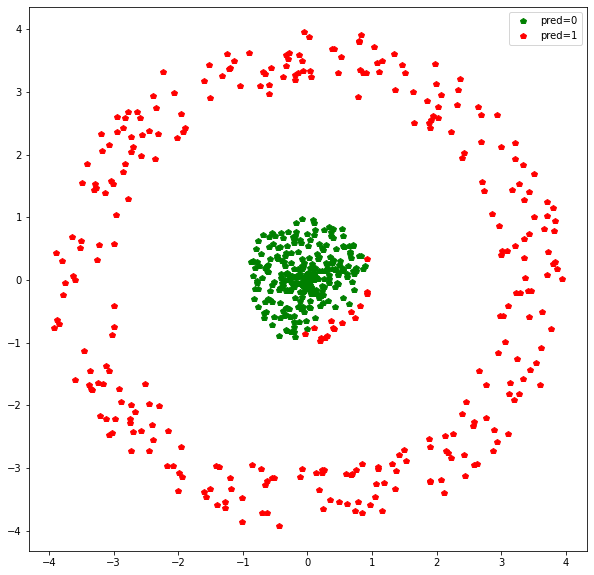

In [156]:
pred = net(torch.from_numpy(X).float())
pred = (pred > 0.5).int().numpy().squeeze(1)

plt.figure(figsize=(10,10))
plt.plot(X[pred==0][:,0], X[pred==0][:, 1], 'p', c='g', label='pred=0')
plt.plot(X[pred==1][:,0], X[pred==1][:, 1], 'p', c='r', label='pred=1')
plt.legend()

Train a bit more

In [158]:
net = train(net, 1000, X, y)

Training accuracy = 0.987
Training accuracy = 0.992
Training accuracy = 0.995
Training accuracy = 1.000
Training accuracy = 1.000
Training accuracy = 1.000
Training accuracy = 1.000
Training accuracy = 1.000
Training accuracy = 1.000
Training accuracy = 1.000


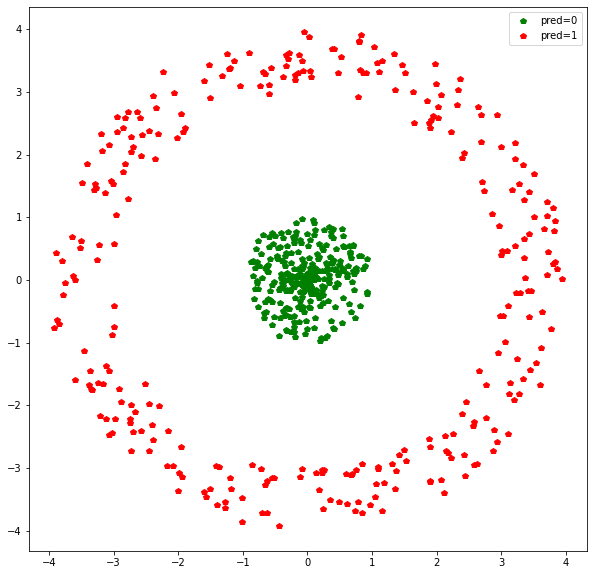

In [159]:
pred = net(torch.from_numpy(X).float())
pred = (pred > 0.5).int().numpy().squeeze(1)

plt.figure(figsize=(10,10))
plt.plot(X[pred==0][:,0], X[pred==0][:, 1], 'p', c='g', label='pred=0')
plt.plot(X[pred==1][:,0], X[pred==1][:, 1], 'p', c='r', label='pred=1')
plt.legend()